## This Jupyter notebook is an example of how to use the backend functions from PROJECT NAME THAT I CANT REMEMBER NOW

Our first cell imports our analyser, as well as numpy and pandas

In [1]:
from functions_backend import analyser
import numpy as np

import pandas as pd

Now we define some functions so that a user can create some generic data.

The functions "rotate" and "normal_cloud" are best called via "separate_gaussians".

"Separate_gaussians" creates two 2D gaussian ellipses, which are then randomly rotated.
It labels one cloud as +ve and one as -ve.

In [2]:

def rotate(X, angle):
    """
    This function rotates an aribitrary set of point coordinates by a given angle (in degrees)
    around the mean centre of the given points.
    X, the point coordinates rotated, is an array of form (n_instances * 2)
    If applied to a distribution of points, has the effect of changing variance and covariance
    
    Arguments:
    X - pointwise coordinates, shape (n_instances,2)
    angle - the angle around the mean centre of the instances to rotate
    """
    
    # Standard form of a counter-clockwise rotational transform by "angle"
    rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                                [np.sin(angle),  np.cos(angle)]])
    
    
    # Centre of the distribution
    x_centre = np.mean(X, axis=0)
    
    # Normalise coordinates to centre at zero
    # necessary for rotation around the distributions own centre
    x_norm = X - x_centre
    
    #Empty array to store rotated coordinates in
    rotated = np.zeros_like(X)
    for i in range(X[:,0].shape[0]):
        #Iterate over points, multiplying each coordinate vector by our rotation matrix
        
        rotated[i,:] = np.matmul(rotation_matrix,x_norm[i,:])
    
    #Move distribution back to its original centre
    rotated += x_centre
    
    return rotated


def normal_cloud(dev_x, dev_y, centre = 0, samples=100, xtrans=0, ytrans=0):
    """Function to generate a gaussian cloud with zero covariance
    
    Arguments:
    dev_x, dev_y - deviations along each axis direction
    centre - initial centre of cloud (redundant)
    samples - the total number of instances in cloud
    xtrans, ytrans - shift the cloud by this amount
    """
    #Initial distribution
    cloud = np.random.normal(centre, (dev_x, dev_y), size=(samples,2))
    
    #Shift cloud by xtrans and ytrans
    cloud[:,0] = cloud[:,0]+xtrans
    cloud[:,1] = cloud[:,1]+ytrans
    
    return cloud


def separate_gaussians(dev_x, dev_y, pos_samples, neg_samples, displacement, rotation = False):
    """
    Function to generate two separate gaussian clouds with variance and optional covariance, each translated away from the origin
    
    Arguments:
    dev_x, dev_y - deviations along x and y axis (ie long and short side of final ellipse)
    pos_samples, neg_samples - number of samples in each class/cloud
    displacement - translation of each cloud away from the origin in opposite directions
    """
    
    
    #Make clouds, first for the positive class
    cloud1 = normal_cloud(dev_y, dev_x, samples = pos_samples, xtrans = displacement, ytrans=displacement)
    cloud2 = normal_cloud(dev_y, dev_x, samples = neg_samples, ytrans=-displacement, xtrans=-displacement)
    
    #If rotation is specified, rotate each distribution by a random amount
    if rotation == True:
        cloud1 = rotate(cloud1, np.random.randint(0,high = 180))
        cloud2 = rotate(cloud2, np.random.randint(0,high = 180))

    #Labels for data
    y_pos = np.zeros((pos_samples)) + 1
    y_neg = np.zeros((neg_samples)) - 1
    

    #Final data
    x = np.append(cloud1, cloud2, axis=0)
    y = np.append(y_pos, y_neg)
    
    return x,y

def embedded_circle(centre_size, cloud_deviation, gap, total_samples):
    """
    Redundant function, not currently used. Generates a gaussian cloud within a ring of a second class
    """
    x = normal_cloud(cloud_deviation, cloud_deviation, samples=total_samples)
    
    x1s = x[:,0]
    x2s = x[:,1]
    distances = np.sqrt(x1s**2+x2s**2)
    
    y = np.zeros(x.shape[0])
    
    y[ distances > centre_size ] = -1
    y[ distances < centre_size ] = 1
    
    x[distances > centre_size,0] += np.sign(x[distances > centre_size,0])*gap
    x[distances > centre_size,1] += np.sign(x[distances > centre_size,1])*gap
    
    return x,y



# Application of analyser to SKLearn toy datasets

In its current form this notebook applies the analyser to the sklearn toy datasets.
The user can change the line
```dataset = datasets.load_wine()```
to any of
```.load_breast_cancer, .load_iris, .load_wine```
for classification examples, or
```.load_diabetes```
for regression.

In [3]:
#First import the sklearn datasets
from sklearn import datasets

def construct_example_dataset(n_dimensions = 2, circular=False):

    #Number of samples for negative and positive class
    pos_samples = 500
    neg_samples = 500
    
    data = pd.DataFrame()
    for i in range(int(n_dimensions/2)):
        if circular == False:
            X_generic, Y_generic = separate_gaussians(2,1.25, pos_samples, neg_samples, 4, rotation = True)
            data[f"X{2*i}"] = X_generic[:,0]
            data[f"X{2*i+1}"] = X_generic[:,1]
        else:
            X_generic, Y_generic = embedded_circle(3, 6, 0.5, pos_samples+neg_samples)
            data[f"X{2*i}"] = X_generic[:,0]
            data[f"X{2*i+1}"] = X_generic[:,1]
        
    
    data["target"] = Y_generic
    
    return data
    
def construct_sklearn_dataset(dataset):

    #Load a given dataset


    X = dataset.data

    try: #try and give string labels - if not use the numeric ones from sklearn
        if dataset.target_names.shape[0] < 10:
            Y = dataset.target_names[dataset.target]
        else:
            Y = dataset.target
    except:
        Y = dataset.target

    #Put the data into a dataframe
    data = pd.DataFrame()

    for i in range(X.shape[1]):
        data[dataset["feature_names"][i]] = X[:,i]
        #data[f"X{i}"] = X[:,i]
    data["target"]  = Y
    
    return data

In [4]:
#data = construct_example_dataset(n_dimensions=2, circular=True)

dataset = datasets.load_breast_cancer()
data = construct_sklearn_dataset(dataset)

#Finally, initiate the analyser
analyse = analyser(data, "target")

analyser active


# Mean separations & feature correlations

The analyser class includes methods to find the separations of class means, as well as feature correlations

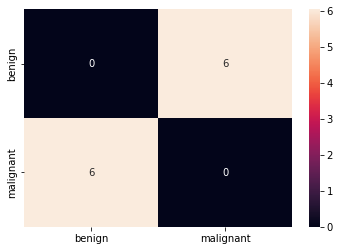

In [5]:
analyse.mean_separations()

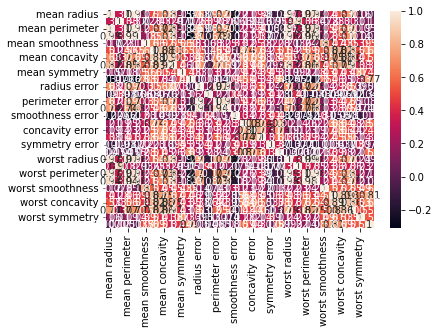

In [6]:
analyse.feature_correlations(display=True)

# The ```.compare(x1,x2)``` method
This allows comparison of any two variables.
It draws confidence interval ellipses around the classes in the given x1 vs x2 dataspace, if the problem is classification.
It also displays histograms of the data in x1 and x2, aligned with the axis.
The main aim here is to check if data is easily separable along the given dimensions.


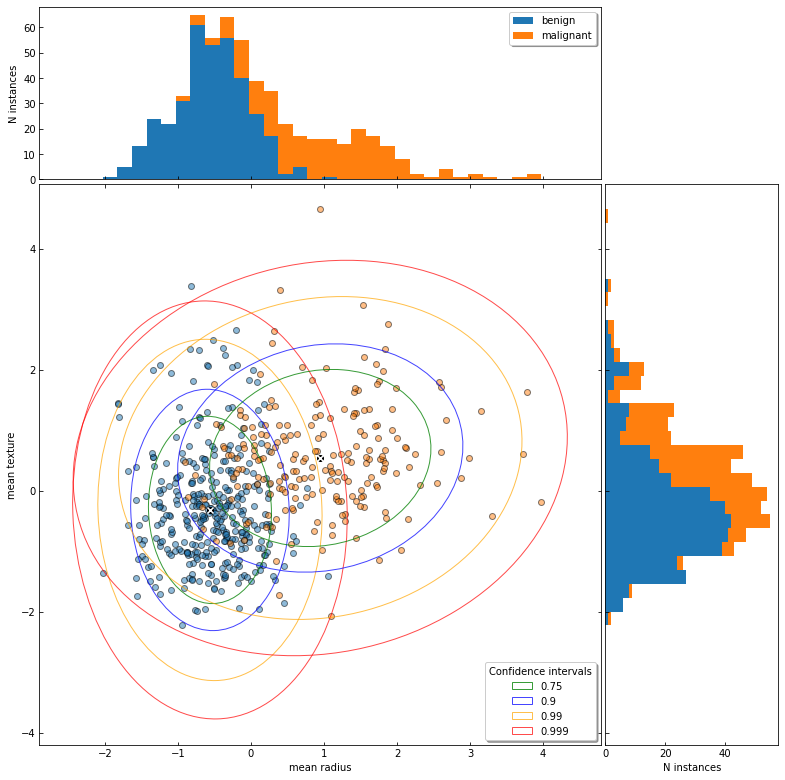

In [7]:
analyse.compare(dataset["feature_names"][0], dataset["feature_names"][1])

# Feature importances

Using SKLearn random forest ensembles allows us to find the comparative utility of features from both a classification and regression perspective.
This is returned to the user, and ```.compare``` is called on the two most "important" features.
Note here that random forests are stochastic in nature, and results may vary between runs on the same data.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.2s finished


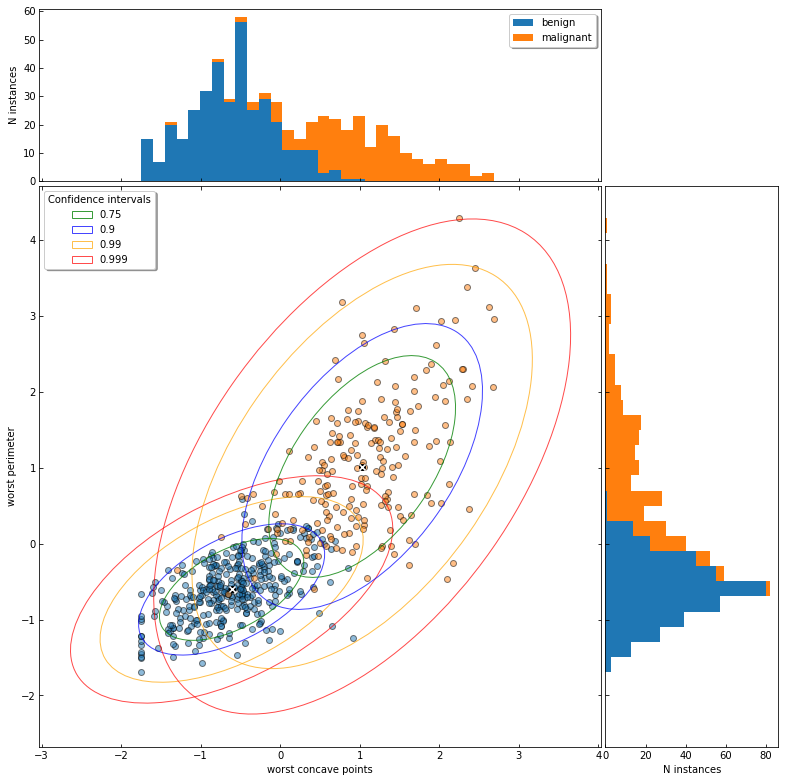

['worst concave points' 'worst perimeter' 'worst area' 'worst radius'
 'mean concave points' 'mean radius' 'mean concavity' 'mean perimeter'
 'area error' 'mean area' 'worst concavity' 'worst texture'
 'worst compactness' 'mean texture' 'perimeter error' 'worst smoothness'
 'radius error' 'worst symmetry' 'mean compactness'
 'worst fractal dimension' 'mean smoothness' 'concavity error'
 'fractal dimension error' 'smoothness error' 'symmetry error'
 'compactness error' 'texture error' 'mean symmetry'
 'concave points error' 'mean fractal dimension']


In [8]:
feature_importances = analyse.feature_importances()
print(feature_importances)

# Linear separability

The class also includes the ```.linear_separable()``` method to test whether data is linearly separable
It also has functionality to use different kernels and different orders within those kernels

In [9]:
analyse.linear_separable(kernel = 'poly', order=3)
analyse.linear_separable(kernel = 'poly', order=1)

Data is linearly separable to an accuracy of 0.9894551845342706
Data is linearly separable to an accuracy of 0.9876977152899824


# Dimensionality reduction

We also include methods to add dimensionality reduction projections to the backend dataframe.
The kwarg ```display``` allows the user to see the result using ```.compare```.

In its current form this is implemented for PCA and TSNE and UMAP.
PCA uses class correlations, whereas TSNE and UMAP attempt to find an embedding of an underlying
manifold in the data-space.

Dimensionality reduction is often useful to find underlying patterns in the data, reduce the number of features passed to
algorithms, or to improve class separability.

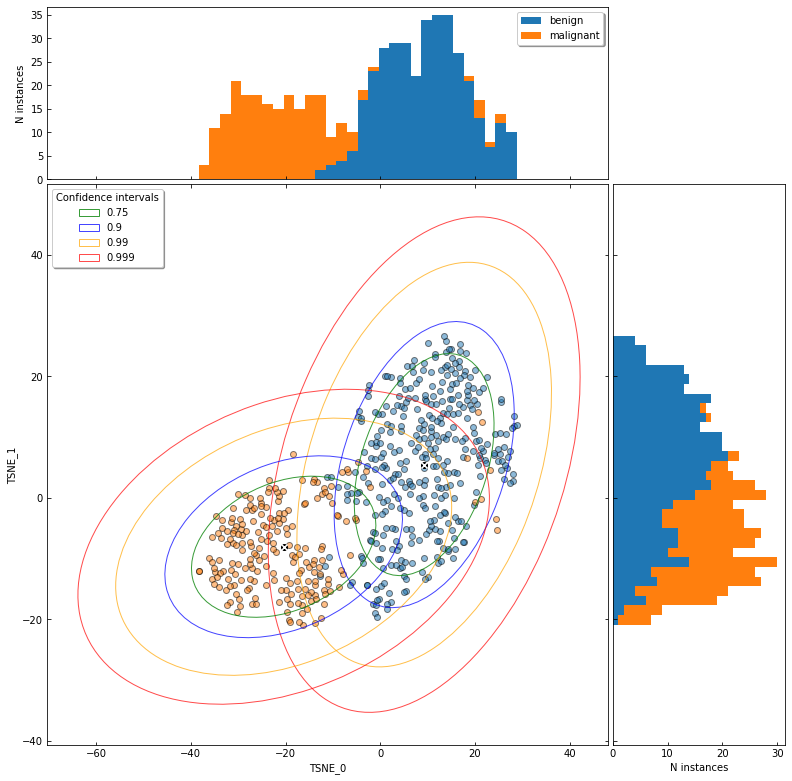

In [10]:
analyse.add_TSNE(display = True)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.2s finished


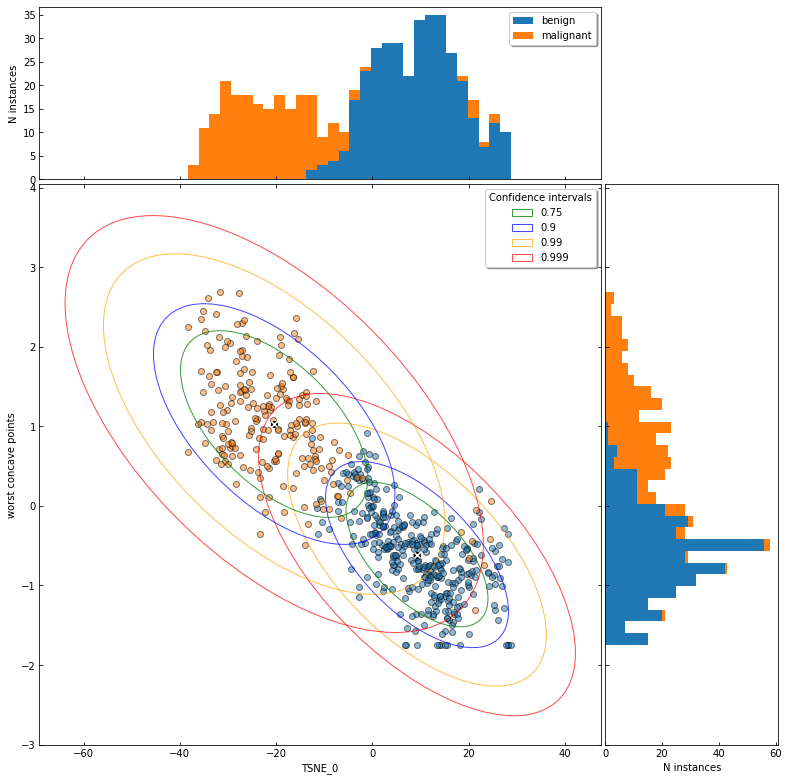

['TSNE_0' 'worst concave points' 'worst perimeter' 'worst radius'
 'mean concave points' 'worst area' 'mean concavity' 'area error'
 'mean perimeter' 'mean area' 'mean radius' 'worst concavity'
 'radius error' 'perimeter error' 'TSNE_1' 'worst texture'
 'worst compactness' 'mean compactness' 'worst symmetry' 'mean texture'
 'worst smoothness' 'concavity error' 'worst fractal dimension'
 'mean smoothness' 'fractal dimension error' 'smoothness error'
 'texture error' 'symmetry error' 'concave points error' 'mean symmetry'
 'compactness error' 'mean fractal dimension']


In [11]:
feature_importances = analyse.feature_importances()
print(feature_importances)

In [12]:
analyse.linear_separable(kernel = 'poly', order=3)
analyse.linear_separable(kernel = 'poly', order=1)

Data is linearly separable to an accuracy of 0.968365553602812
Data is linearly separable to an accuracy of 0.9806678383128296
